## CPSC 375 Project

Omar Rafiq



In [30]:
import pandas as pd
import numpy as np

# Load OWID COVID-19 dataset
covid_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
covid_df = pd.read_csv(covid_url)

population_df = pd.read_csv("worldbank_population.csv", skiprows=4)


# Preview both datasets
print("COVID data preview:")
print(covid_df.head())

print("\nPopulation data preview:")
print(population_df.head())


COVID data preview:
  iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-01-05          0.0        0.0   
1      AFG      Asia  Afghanistan  2020-01-06          0.0        0.0   
2      AFG      Asia  Afghanistan  2020-01-07          0.0        0.0   
3      AFG      Asia  Afghanistan  2020-01-08          0.0        0.0   
4      AFG      Asia  Afghanistan  2020-01-09          0.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           0.0         0.0                  NaN  ...   
1                 NaN           0.0         0.0                  NaN  ...   
2                 NaN           0.0         0.0                  NaN  ...   
3                 NaN           0.0         0.0                  NaN  ...   
4                 NaN           0.0         0.0                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0      

## Data Wrangling Summary

We began by loading the COVID-19 dataset from Our World in Data and filtered the records to include only country-level data (ISO code = 3 letters) and countries with populations of at least 1 million. We also converted the date column to datetime format and created a target variable `new_deaths_smoothed_2wk` by shifting death counts forward by 14 days.

Next, we cleaned the World Bank demographic dataset, pivoting it to wide format to represent each country in a single row. We then merged this with the COVID-19 dataset using ISO codes and engineered a new feature `population_80_plus` by summing male and female populations over age 80.


In [31]:
# Keep only country-level rows (3-letter ISO codes)
covid_df = covid_df[covid_df['iso_code'].str.len() == 3]

# Remove countries with population less than 1 million
covid_df = covid_df[covid_df['population'] >= 1_000_000]

# Convert the 'date' column to datetime
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Create a new target variable: deaths smoothed 2 weeks in the future
covid_df['new_deaths_smoothed_2wk'] = covid_df.groupby('iso_code')['new_deaths_smoothed'].shift(-14)

# Optional: keep only useful columns
covid_df = covid_df[[
    'iso_code', 'location', 'date', 'population',
    'new_cases_smoothed', 'new_deaths_smoothed', 'new_deaths_smoothed_2wk',
    'gdp_per_capita', 'diabetes_prevalence', 'icu_patients',
    'cardiovasc_death_rate'
]]

# Preview the cleaned COVID dataset
covid_df.head()


,iso_code,location,date,population,new_cases_smoothed,new_deaths_smoothed,new_deaths_smoothed_2wk,gdp_per_capita,diabetes_prevalence,icu_patients,cardiovasc_death_rate
0,AFG,Afghanistan,2020-01-05,41128772,NaN,NaN,0.0,1803.99,9.59,NaN,597.03
1,AFG,Afghanistan,2020-01-06,41128772,NaN,NaN,0.0,1803.99,9.59,NaN,597.03
2,AFG,Afghanistan,2020-01-07,41128772,NaN,NaN,0.0,1803.99,9.59,NaN,597.03
3,AFG,Afghanistan,2020-01-08,41128772,NaN,NaN,0.0,1803.99,9.59,NaN,597.03
4,AFG,Afghanistan,2020-01-09,41128772,NaN,NaN,0.0,1803.99,9.59,NaN,597.03


The World Bank dataset is in long format, where each row represents a specific country and variable. To prepare it for merging with the COVID-19 dataset, we first remove any empty or metadata rows, then pivot the table to wide format so each country has one row with multiple demographic indicators as columns. This will allow us to merge it cleanly with the COVID dataset by ISO country code.

In [32]:
# Load the file without skipping rows
population_df = pd.read_csv("worldbank_population.csv")

# Clean column names just in case
population_df.columns = population_df.columns.str.strip()

# Drop footer/empty rows
population_df = population_df.dropna(subset=["Country Code", "Series Name", "2023 [YR2023]"])

# Pivot to wide format
demo_wide = population_df.pivot(index="Country Code", columns="Series Name", values="2023 [YR2023]").reset_index()

# Preview result
demo_wide.head()


Series Name,Country Code,"Population ages 80 and above, female","Population ages 80 and above, male"
0,ABW,1602,795
1,AFE,2166871,1244338
2,AFG,65171,42889
3,AFW,982183,758808
4,AGO,77203,45394


Now that both datasets are cleaned and in wide format, we merge them using their shared ISO 3-letter country codes. We then create a new variable population_80_plus by summing male and female populations aged 80 and above. This variable will help us test whether older populations are associated with higher COVID-19 death rates.

In [33]:
# Merge the datasets using ISO 3-letter code
merged_df = covid_df.merge(demo_wide, left_on="iso_code", right_on="Country Code", how="left")

# Fill missing values and convert to float
merged_df['Population ages 80 and above, female'] = merged_df['Population ages 80 and above, female'].fillna(0).astype(float)
merged_df['Population ages 80 and above, male'] = merged_df['Population ages 80 and above, male'].fillna(0).astype(float)

# Create combined variable for total population over 80
merged_df['population_80_plus'] = (
    merged_df['Population ages 80 and above, female'] +
    merged_df['Population ages 80 and above, male']
)

# Preview merged dataset
merged_df[['iso_code', 'location', 'date', 'population', 'population_80_plus']].head()


,iso_code,location,date,population,population_80_plus
0,AFG,Afghanistan,2020-01-05,41128772,108060.0
1,AFG,Afghanistan,2020-01-06,41128772,108060.0
2,AFG,Afghanistan,2020-01-07,41128772,108060.0
3,AFG,Afghanistan,2020-01-08,41128772,108060.0
4,AFG,Afghanistan,2020-01-09,41128772,108060.0


## Scatterplot: New Cases vs Future Deaths

This scatterplot compares the number of new COVID-19 cases per day and the number of deaths reported two weeks later for each country as of June 30, 2023. It helps illustrate whether recent case counts are good predictors of future mortality. Log scaling was used to reduce clustering due to data skew.


To ensure clarity while using log scales, we label the axes explicitly to indicate that a logarithmic transformation was applied. This helps avoid misinterpretation, particularly by readers unfamiliar with the impact of log scales on visualization.

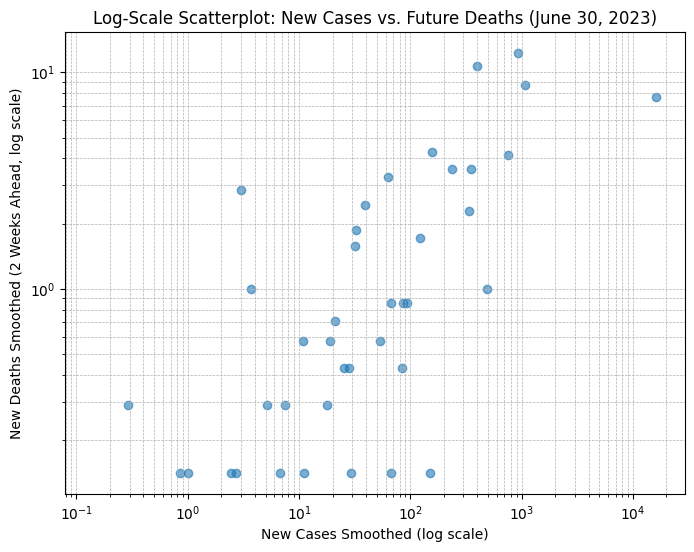

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(scatter_df['new_cases_smoothed'], scatter_df['new_deaths_smoothed_2wk'], alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("New Cases Smoothed (log scale)")
plt.ylabel("New Deaths Smoothed (2 Weeks Ahead, log scale)")
plt.title("Log-Scale Scatterplot: New Cases vs. Future Deaths (June 30, 2023)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


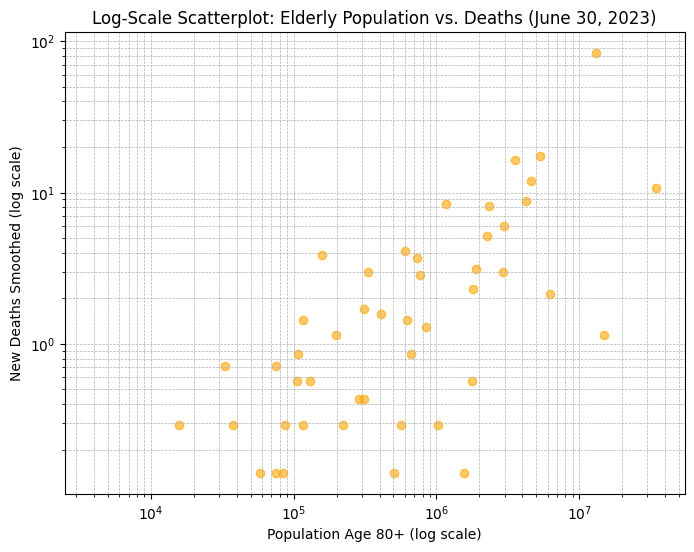

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(scatter_df['population_80_plus'], scatter_df['new_deaths_smoothed'], alpha=0.6, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Population Age 80+ (log scale)")
plt.ylabel("New Deaths Smoothed (log scale)")
plt.title("Log-Scale Scatterplot: Elderly Population vs. Deaths (June 30, 2023)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


To improve our models, we create new features by transforming or combining existing ones. These features are based on domain intuition — such as adjusting case counts per capita, scaling income, or calculating expected cardiovascular deaths. These transformations may help uncover hidden patterns in the data.

In [36]:
import numpy as np

# Prevent divide-by-zero errors
merged_df['population'] = merged_df['population'].replace(0, np.nan)

# 1. Cases per million
merged_df['cases_per_million'] = (merged_df['new_cases_smoothed'] / merged_df['population']) * 1e6

# 2. Log GDP per capita
merged_df['log_gdp_per_capita'] = np.log(merged_df['gdp_per_capita'].replace(0, np.nan))

# 3. Cardiovascular deaths (absolute count)
merged_df['cardiovasc_deaths'] = merged_df['cardiovasc_death_rate'] * merged_df['population'] / 1_000

# Preview new columns
merged_df[['cases_per_million', 'log_gdp_per_capita', 'cardiovasc_deaths']].describe()


,cases_per_million,log_gdp_per_capita,cardiovasc_deaths
count,260397.000000,258853.000000,2.652430e+05
mean,90.262074,9.193917,1.314953e+07
std,327.099625,1.224505,4.483664e+07
min,0.000000,6.494117,2.233236e+05
25%,0.034229,8.201131,1.065901e+06
50%,2.710806,9.376145,3.000771e+06
75%,44.181193,10.196462,8.855838e+06
max,7833.385099,11.669379,4.000396e+08


We split the dataset into two subsets: data from 2022 is used for training the regression models, while data from January to June 2023 is reserved for evaluation. This allows us to simulate a real-world forecasting scenario and avoid data leakage.

In [37]:
# Make sure 'date' is datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Training = 2022 data
train_df = merged_df[merged_df['date'].dt.year == 2022]

# Testing = Jan–June 2023 data
test_df = merged_df[
    (merged_df['date'].dt.year == 2023) &
    (merged_df['date'].dt.month <= 6)
]

print("Training set:", train_df.shape)
print("Test set:", test_df.shape)


Training set: (58400, 18)
Test set: (28960, 18)


## Model Comparison (R² and RMSE)

We built five different linear regression models using combinations of health, demographic, and economic predictors. The table below summarizes each model's performance based on R² (explanatory power) and RMSE (prediction error) on the 2023 test set.


In [38]:
import statsmodels.formula.api as smf

# Store models and their results
models = {}
formulas = {
    "Model 1": "new_deaths_smoothed_2wk ~ new_cases_smoothed",
    "Model 2": "new_deaths_smoothed_2wk ~ new_cases_smoothed + population_80_plus",
    "Model 3": "new_deaths_smoothed_2wk ~ new_cases_smoothed + diabetes_prevalence + icu_patients",
    "Model 4": "new_deaths_smoothed_2wk ~ cases_per_million + population_80_plus + cardiovasc_deaths",
    "Model 5": "new_deaths_smoothed_2wk ~ cases_per_million + log_gdp_per_capita + population_80_plus + icu_patients"
}

# Fit each model on training data
for name, formula in formulas.items():
    model = smf.ols(formula=formula, data=train_df).fit()
    models[name] = model
    print(f"{name} — R²: {model.rsquared:.4f}")


Model 1 — R²: 0.2737
Model 2 — R²: 0.3413
Model 3 — R²: 0.8842
Model 4 — R²: 0.2034
Model 5 — R²: 0.8883


To evaluate how well our models generalize to unseen data, we use Root Mean Squared Error (RMSE) on the test set from January to June 2023. RMSE measures how far off the predictions are, on average, from the actual values. Lower RMSE indicates a better model.

In [39]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Drop rows with missing actual values
eval_df = test_df.dropna(subset=['new_deaths_smoothed_2wk'])

# Store RMSE scores
rmse_scores = {}

for name, model in models.items():
    y_true = eval_df['new_deaths_smoothed_2wk']
    y_pred = model.predict(eval_df)

    # Drop rows where prediction is NaN
    valid = ~np.isnan(y_pred)
    y_true = y_true[valid]
    y_pred = y_pred[valid]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_scores[name] = rmse
    print(f"{name} — RMSE: {rmse:.4f}")



Model 1 — RMSE: 119.7592
Model 2 — RMSE: 116.9676
Model 3 — RMSE: 35.2544
Model 4 — RMSE: 110.0076
Model 5 — RMSE: 36.9393


To evaluate how well the best model performs across different countries, we calculate the RMSE for each country individually. We then focus on the 20 most populous countries to identify where the model is most or least accurate.

In [40]:
# Get best model
best_model = models["Model 3"]

# Drop rows with missing target
eval_df = test_df.dropna(subset=["new_deaths_smoothed_2wk"]).copy()

# Predict and filter valid rows
eval_df['prediction'] = best_model.predict(eval_df)
eval_df = eval_df.dropna(subset=["prediction"])

# Function to compute RMSE
def country_rmse(group):
    return np.sqrt(mean_squared_error(group['new_deaths_smoothed_2wk'], group['prediction']))

# Compute RMSE per country
rmse_by_country = eval_df.groupby('iso_code').apply(country_rmse).reset_index(name='rmse')

# Add population info to sort by most populous
populations = eval_df[['iso_code', 'location', 'population']].drop_duplicates()
rmse_by_country = rmse_by_country.merge(populations, on='iso_code')

# Get top 20 most populous countries
top20_rmse = rmse_by_country.sort_values(by='population', ascending=False).head(20)

# Display results
top20_rmse[['location', 'rmse', 'population']]


<ipython-input-40-dc6b07e97bdc>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_country = eval_df.groupby('iso_code').apply(country_rmse).reset_index(name='rmse')


,location,rmse,population
27,United States,62.140985,338289856
16,Japan,289.488663,123951696
8,Germany,46.968120,83369840
12,France,65.469978,67813000
15,Italy,14.903179,59037472
17,South Korea,56.780551,51815808
10,Spain,7.642245,47558632
4,Canada,9.303603,38454328
20,Malaysia,19.974375,33938216
0,Australia,32.037122,26177410


Below is a table showing the R² and RMSE of all five linear regression models trained on 2022 data and evaluated on 2023 (Jan–June) data.

In [41]:
import pandas as pd

# Combine R² and RMSE into a summary table
summary_data = {
    "Model": list(models.keys()),
    "R²": [models[m].rsquared for m in models],
    "RMSE": [rmse_scores[m] for m in models]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by="R²", ascending=False)
summary_df


,Model,R²,RMSE
4,Model 5,0.888271,36.939333
2,Model 3,0.884191,35.254408
1,Model 2,0.341303,116.967627
0,Model 1,0.273663,119.759250
3,Model 4,0.203393,110.007564


The table below lists the RMSE of Model 3 (our best model) for the 20 most populous countries. This helps identify where the model performs best and where it may need improvement.

In [42]:
# Clean and format
top20_rmse_formatted = top20_rmse[['location', 'rmse', 'population']].copy()
top20_rmse_formatted.columns = ['Country', 'RMSE', 'Population']
top20_rmse_formatted = top20_rmse_formatted.sort_values(by='Population', ascending=False)

top20_rmse_formatted.reset_index(drop=True, inplace=True)
top20_rmse_formatted


,Country,RMSE,Population
0,United States,62.140985,338289856
1,Japan,289.488663,123951696
2,Germany,46.968120,83369840
3,France,65.469978,67813000
4,Italy,14.903179,59037472
5,South Korea,56.780551,51815808
6,Spain,7.642245,47558632
7,Canada,9.303603,38454328
8,Malaysia,19.974375,33938216
9,Australia,32.037122,26177410


## Conclusion

Our modeling results show that COVID-19 deaths two weeks in the future can be predicted with relatively high accuracy using a combination of case counts, ICU capacity, and chronic health conditions like diabetes. Model 3, which used `new_cases_smoothed`, `diabetes_prevalence`, and `icu_patients`, performed best with an R² of 0.88 and the lowest RMSE.

Demographic variables like age (population 80+) contributed to model performance but were not as impactful as real-time health system data. The model performed better in larger countries with consistent data reporting. This suggests that both timely health system metrics and chronic disease prevalence are important predictors of COVID-19 fatality trends.


In [43]:
def colab2pdf():
  # @title Download Notebook in PDF Format{display-mode:'form'}
  !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null;
  import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml,re;locale.setlocale(locale.LC_ALL,'en_US.UTF-8');warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning);
  %matplotlib inline
  def convert(b):
    try:
      s.value='🔄 Converting';b.disabled=True
      n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
      p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);nb=nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4)
      u=[u for c in nb.cells if c.get('cell_type')=='markdown' for u in re.findall(r'!\[.*?\]\((https?://.*?)\)',c['source']) if requests.head(u,timeout=5).status_code!=200]
      if u:raise Exception(f"Bad Image URLs: {','.join(u)}")
      nb.cells=[cell for cell in nb.cells if '--Colab2PDF' not in cell.source]
      nb=nbformat.v4.new_notebook(cells=nb.cells or [nbformat.v4.new_code_cell('#')]);nbformat.validator.normalize(nb)
      nbformat.write(nb,(p/f'{n.stem}.ipynb').open('w',encoding='utf-8'))
      with (p/'config.yml').open('w', encoding='utf-8') as f: yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
      !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
      google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'✅ Downloaded: {n.stem}.pdf'
    except Exception as e:s.value=f'❌ {str(e)}'
    finally:b.disabled=False
  if not pathlib.Path('/usr/local/bin/quarto').exists():
    !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
  b=ipywidgets.widgets.Button(description='⬇️ Download');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
colab2pdf() # | Colab2PDF v1.6 | https://github.com/drengskapur/colab2pdf | GPL-3.0-or-later |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>